# Short Interest Rate Model Hull-White and Monte Carlo

---
Ouijdane ABCHIR, April 2024.
---
About this notebook : 
---

- **Summary** : This notebook presents a Python implementation of the Hull-White model, the pricing of a caplet with the marginality tests.



In [1]:
import math
import numpy as np
from math import exp, floor, log, sqrt
import matplotlib.pyplot as plt
import pandas as pd

Parameters

In [2]:
r0 = 0.02990  # Initial short rate
T = 1.0  # Time to caplet expiration or maturity of the option
a = 0.2  # Mean reversion speed parameter (hypothesis)
sigma = 0.02  # Annual volatility parameter (hypothesis)
K = 0.03  # Caplet strike rate
num_paths = 1000  # Number of Monte Carlo paths
length_sim = 20 # Simulation the short term rates on X years
num_steps_year = 360  # Number of time steps a year
dt = 1 / num_steps_year  # Time step a year
t=0
nominal = 10
tenor = 6/12 #6 mois pour euribor 6 mois
S = T + tenor # bond maturity from t0 and when the flows are exchanged

Extraction of the instantaneous forward rate from the market

In [3]:
data = pd.read_excel(r'Courbes de taux.xlsm',sheet_name='raw_data')
data = data.to_numpy()
time = data[:,0] 
instantaneous_forward_rate = data[:,3] #from the market

time_extended = np.arange(0, length_sim, dt) #0.00277778 = 1/360 = dt
forward_extended = np.interp(time_extended, time, instantaneous_forward_rate)

Plot of the instantaneous forward rates

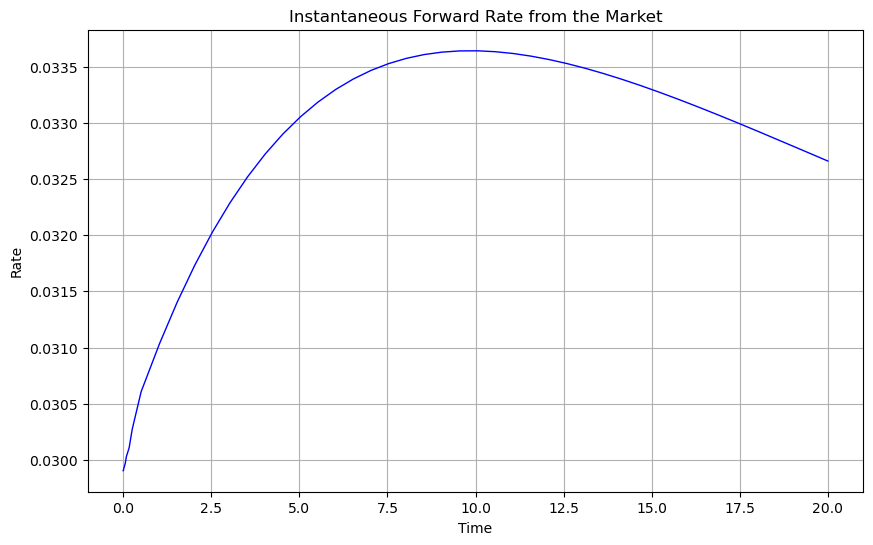

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(time_extended, forward_extended, color='blue', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('Instantaneous Forward Rate from the Market')
plt.grid(True)
plt.show()

Theta calculation

In [5]:
theta = np.zeros((num_paths,len(time_extended)))
theta[:,0] = a*forward_extended[0]
for i in range(1,len(time_extended)):
    diff_f = (forward_extended[i]-forward_extended[i-1])/(time_extended[i]-time_extended[i-1])
    theta[:,i] =  diff_f + a*forward_extended[i] + sigma**2*(1-exp(-2*a*time_extended[i]))/(2*a)

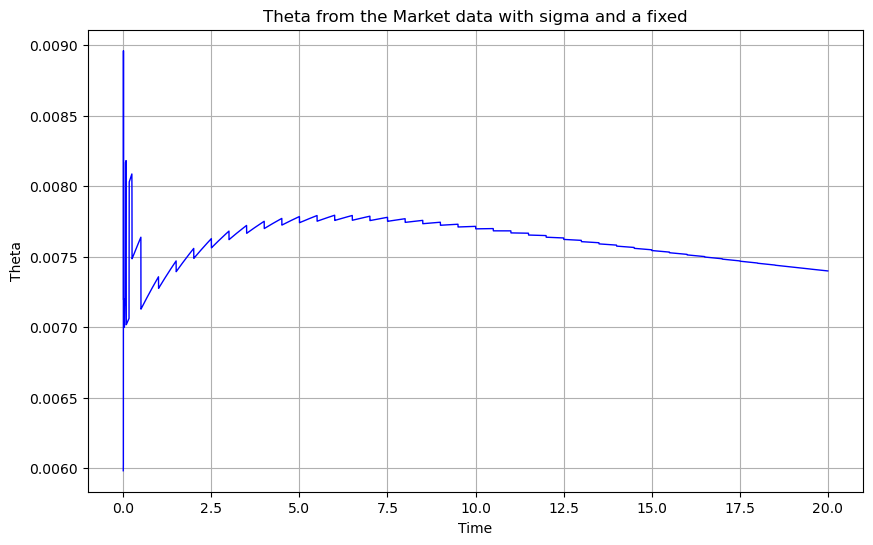

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(time_extended, theta[0,:], color='blue', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta from the Market data with sigma and a fixed')
plt.grid(True)
plt.show()

Monte Carlo process under Hull and White model

In [7]:
#Hull and White diffusion uder Monte Carlo
def hull_white_paths(r0, num_paths, num_steps_year, dt, a, sigma):
    r = np.zeros((num_paths, len(time_extended)))
    r[:, 0] = r0
    for j in range(1, len(time_extended)):
        dW = np.random.normal(0,1,num_paths)
        drift = (theta[:,j-1] - a * r[:, j-1]) * dt
        diffusion = sigma/sqrt(num_steps_year) * dW
        r[:, j] = r[:, j-1] + drift + diffusion #dr = drift + diffusion
    return r

short_rate_paths = hull_white_paths(r0, num_paths, num_steps_year, dt, a, sigma)


Simulated and theortical short rate mean

In [8]:
#Short rate mean from MC
short_mean = np.mean(short_rate_paths,axis=0)

#Short rate mean from theoretical formula
def H_W_mean(i, t, a):
    return forward_extended[i] + sigma ** 2 * (1-np.exp(-a*t))**2 / (2*a**2)

theoretical_mean = np.zeros(len(time_extended))
for i in range(len(time_extended)):
    theoretical_mean[i] = H_W_mean(i, time_extended[i], a)

Plot of the MC simulations (short term rates)

In [9]:
#plt.figure(figsize=(10, 6))
#for i in range(num_paths):
#    plt.plot(time_extended, short_rate_paths[i], linewidth=0.8)
#plt.xlabel('Time')
#plt.ylabel('Short Rate')
#plt.title('Short Rate Paths')
#plt.grid(True)
#plt.show()

Plot of the short term mean of the MC simulations and theoretically

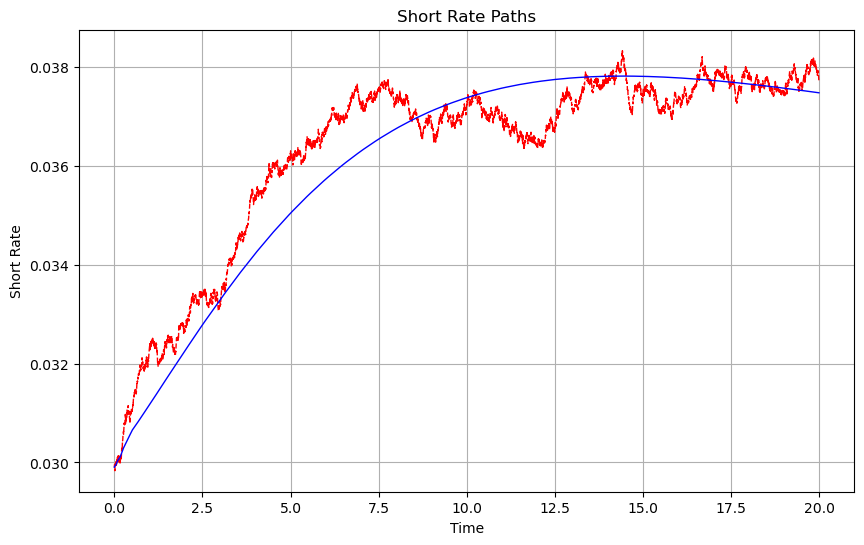

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(time_extended, short_mean, color='red', linestyle='--', linewidth=1)
plt.plot(time_extended, theoretical_mean, color='blue', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Short Rate')
plt.title('Short Rate Paths')
plt.grid(True)
plt.show()

Caplet pricing

In [11]:
def caplet_price_calculation(r, K, T, S, nominal):
    caplet_price = np.zeros((r.shape[0],1))
    for i in range(r.shape[0]):
        forward_rate = (1/(S-T))*(exp(-np.sum(r[i, :floor(T*num_steps_year)])*dt)/exp(-np.sum(r[i, :floor(S*num_steps_year)])*dt)-1)
        payoff = nominal * tenor * max(forward_rate - K, 0)
        caplet_price[i, 0] = payoff * exp(-dt*sum(r[i,:floor(S*num_steps_year)]))
    return caplet_price
caplet_prices = caplet_price_calculation(short_rate_paths, K, T, S, nominal)

caplet_price_avg = np.mean(caplet_prices[:, 0])
print("Caplet Price on average:", caplet_price_avg)

Caplet Price on average: 0.040710145904617204
Caplet Price on average: 0.040710145904617204


Confidence interval

In [12]:
variance = np.zeros((num_paths,1))
for i in range(num_paths):
    variance[i,0] = (caplet_prices[i,0]-caplet_price_avg)**2
variance_avg = (1/(num_paths-1))*sum(variance)

q=2 #convention
lower_bound = caplet_price_avg - q*sqrt(variance_avg/num_paths)
upper_bound = caplet_price_avg + q*sqrt(variance_avg/num_paths)
interval = [lower_bound,upper_bound]

print("Caplet Price 95% confidence interval:", interval)

Caplet Price 95% confidence interval: [0.03725364817892946, 0.044166643630304946]


Plots of the caplets distribution

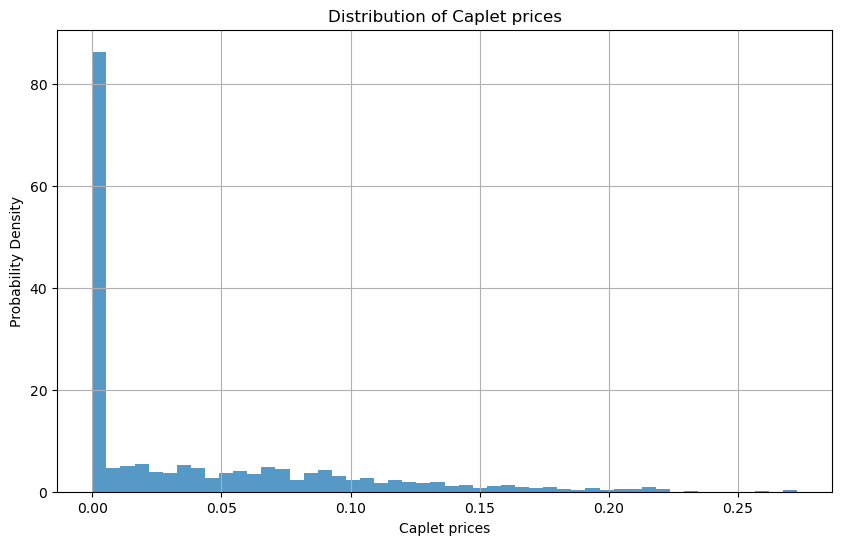

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(caplet_prices[:, -1], bins=50, density=True, alpha=0.75)
plt.xlabel('Caplet prices')
plt.ylabel('Probability Density')
plt.title('Distribution of Caplet prices')
plt.grid(True)
plt.show()

Discount factors from the Monte Carlo simulations and the market

In [14]:
# Discount factors from the Monte Carlo simulation
list_D = np.exp(-short_mean)

#Discount factors from the market
list_B = np.exp(-forward_extended)

ratio= list_D/list_B

Plot of the martingality tests

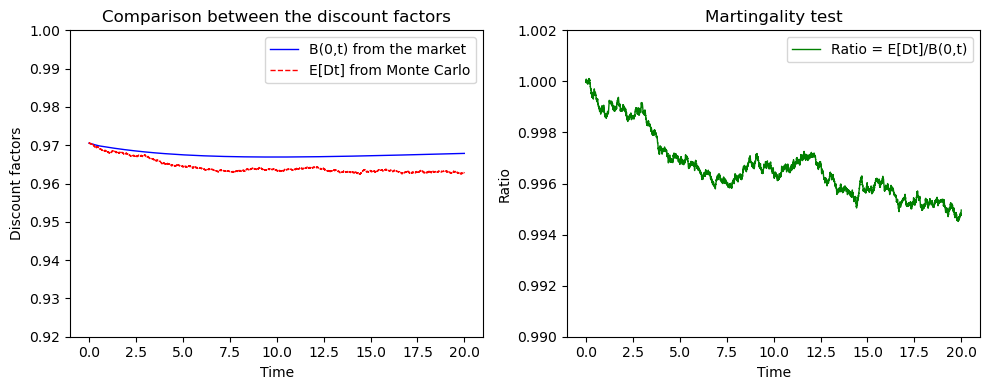

In [15]:
plt.figure(figsize=(10, 4)) 

plt.subplot(1, 2, 1)
plt.plot(time_extended, list_B, label='B(0,t) from the market', color='blue', linestyle='-', linewidth=1)
plt.plot(time_extended, list_D, label='E[Dt] from Monte Carlo', color='red', linestyle='--', linewidth=1)
plt.ylim(0.92,1)
plt.xlabel('Time')
plt.ylabel('Discount factors')
plt.title('Comparison between the discount factors')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_extended, ratio, label='Ratio = E[Dt]/B(0,t)', color='green', linestyle='-', linewidth=1)
plt.ylim(0.99,1.002)
plt.xlabel('Time')
plt.ylabel('Ratio')
plt.title('Martingality test')
plt.legend()

plt.tight_layout()
plt.show()


Plot of the variance test

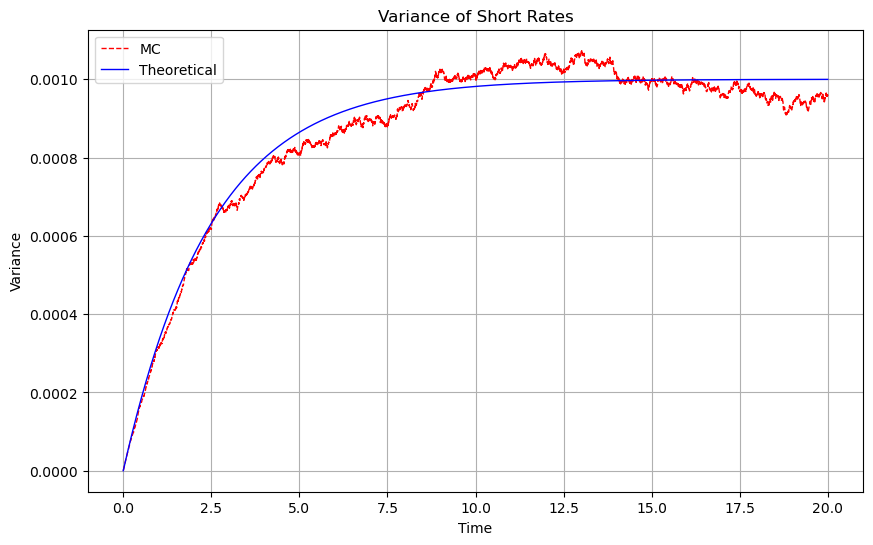

In [16]:
#Variance from the MC simulations
var = np.zeros((len(time_extended)))
for i in range(len(time_extended)):
    var[i] = np.var(short_rate_paths[:, i])

#Variance from the theoretical formula
var_theo = sigma*sigma/(2*a)*(1.0-np.exp(-2.0*a*np.array(np.arange(len(time_extended)) * dt)))

plt.figure(figsize=(10, 6))
plt.plot(time_extended, var, label='MC', color='red', linestyle='--', linewidth=1)
plt.plot(time_extended, var_theo, label='Theoretical', color='blue', linestyle='-', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend()
plt.title("Variance of Short Rates")
plt.grid(True)
plt.show()